In [118]:
import numpy as np
import pandas as pd

import openmdao.api as om

import matplotlib.pyplot as plt
import tools_cvf

plt.style.use(tools_cvf.get_stylesheets(dark=True))

In [119]:

# This function loads the openmdao sql file and does most of the work here
def load_OMsql(log):
    print('loading {}'.format(log))
    cr = om.CaseReader(log)
    rec_data = {}
    # driver_cases = cr.list_cases('driver')
    cases = cr.get_cases('driver')
    for case in cases:
        for key in case.outputs.keys():
            if key not in rec_data:
                rec_data[key] = []
            rec_data[key].append(case[key])
    return rec_data

%cd ~/codes/WEIS/examples/17_IEA22_Optimization

/Users/cfrontin/codes/WEIS/examples/17_IEA22_Optimization


In [120]:
fn_log_template = "32_DesignRound1_%s/log_opt.sql"

fn_log_COBYLA = fn_log_template % "COBYLA"
fn_log_SLSQP = fn_log_template % "SLSQP"

dataOM_COBYLA = load_OMsql(fn_log_COBYLA)
dataOM_SLSQP = load_OMsql(fn_log_SLSQP)
print()
if len(set(dataOM_COBYLA).difference(dataOM_SLSQP)):
  print("the following keys are only in COBYLA:")
for key_m in set(dataOM_COBYLA).difference(dataOM_SLSQP):
  print(f"\t{key_m}")
if len(set(dataOM_SLSQP).difference(dataOM_COBYLA)):
  print("the following keys are only in SLSQP:")
for key_m in set(dataOM_SLSQP).difference(dataOM_COBYLA):
  print(f"\t{key_m}")
keys_all = set(dataOM_COBYLA).intersection(dataOM_SLSQP)
print("the following keys are in both:")
for key_m in keys_all:
  print(f"\t{key_m}")
print()
# dataOM_working = load_OMsql("32_DesignRound1/log_opt.sql")
# keys_all = set(dataOM_working)

keys_obj = [
  "floatingse.system_structural_mass",
]
keys_DV = [
  *sorted([key for key in keys_all if "jointdv" in key]),
  *sorted([key for key in keys_all if ("memgrp" in key) and ("outer_diameter_in" in key)]),
]
keys_constr = {
  **dict.fromkeys([key for key in keys_all if "constr_" in key], [None, 1.0].copy()),
  "raft.Max_PtfmPitch": [None, 7.5],
  "raft.Std_PtfmPitch": [None, 0.39],
  # "raft.max_nac_accel": [None, 0.25],
  # "raft.heave_period": [16., 80.],
  # "raft.pitch_period": [20., 80.],
  "floatingse.metacentric_height": [15.0, None],
}

print()
[
  print(
    f"** {key}" if key in keys_obj
      else f"-- {key}" if key in keys_DV
      else f"<> {key}" if key in keys_constr
      else f"?? {key}"
  ) for key in keys_all
]
print()

loading 32_DesignRound1_COBYLA/log_opt.sql
loading 32_DesignRound1_SLSQP/log_opt.sql

the following keys are in both:
	raft.Max_PtfmPitch
	floatingse.system_structural_mass
	floating.jointdv_0
	floating.memgrp1.outer_diameter_in
	raft.Std_PtfmPitch
	floatingse.metacentric_height
	floating.jointdv_1


?? raft.Max_PtfmPitch
** floatingse.system_structural_mass
-- floating.jointdv_0
-- floating.memgrp1.outer_diameter_in
?? raft.Std_PtfmPitch
<> floatingse.metacentric_height
-- floating.jointdv_1



In [121]:
def plot_conv(keyset_in):
    if len(keyset_in) == 0: return

    fig, axes = plt.subplots(
        len(keyset_in), 1,
        sharex=True, figsize=(6,4*len(keyset_in)), squeeze=False,
    )

    has_ref_vals = type(keyset_in) == dict

    if has_ref_vals:
        key_val_map = keyset_in
        keyset = keyset_in.keys()
    else:
        keyset = keyset_in

    for imethod, method in enumerate(["COBYLA", "SLSQP"]):
        axes[0, 0].plot(
            [], [],
            "w"+("-." if method == "COBYLA" else "--" if method == "SLSQP" else "-"),
            label=method,
        )
        dataOM = dataOM_COBYLA if method == "COBYLA" else (dataOM_SLSQP if method == "SLSQP" else None)
        for idx_ax, key in enumerate(keyset):
            if has_ref_vals and (imethod == 0):
                cval = key_val_map[key]
                if cval[0] is not None: axes[idx_ax, 0].plot([0, len(dataOM[key])], [cval[0], cval[0]], "b:", label="_lower bound_")
                if cval[1] is not None: axes[idx_ax, 0].plot([0, len(dataOM[key])], [cval[1], cval[1]], "r:", label="_upper bound_")
            axes[idx_ax, 0].plot(
                np.squeeze(dataOM[key]),
                "-." if method == "COBYLA" else "--" if method == "SLSQP" else "-",
                label="".join(["_", method, "_"]),
            )
            axes[idx_ax, 0].set_title(key)
    if has_ref_vals:
        axes[0, 0].plot([], [], "b:", label="lower bound")
        axes[0, 0].plot([], [], "r:", label="upper bound")
    axes[0, 0].legend()
    fig.tight_layout()

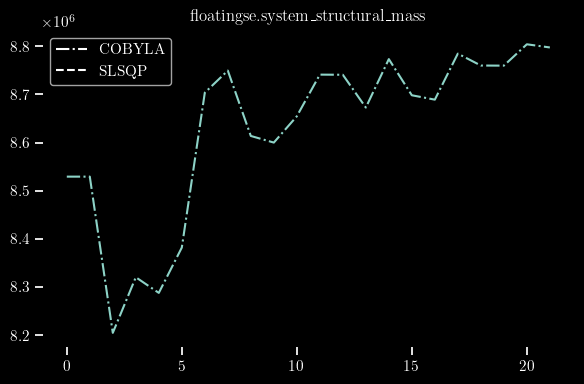

In [122]:
plot_conv(keys_obj)

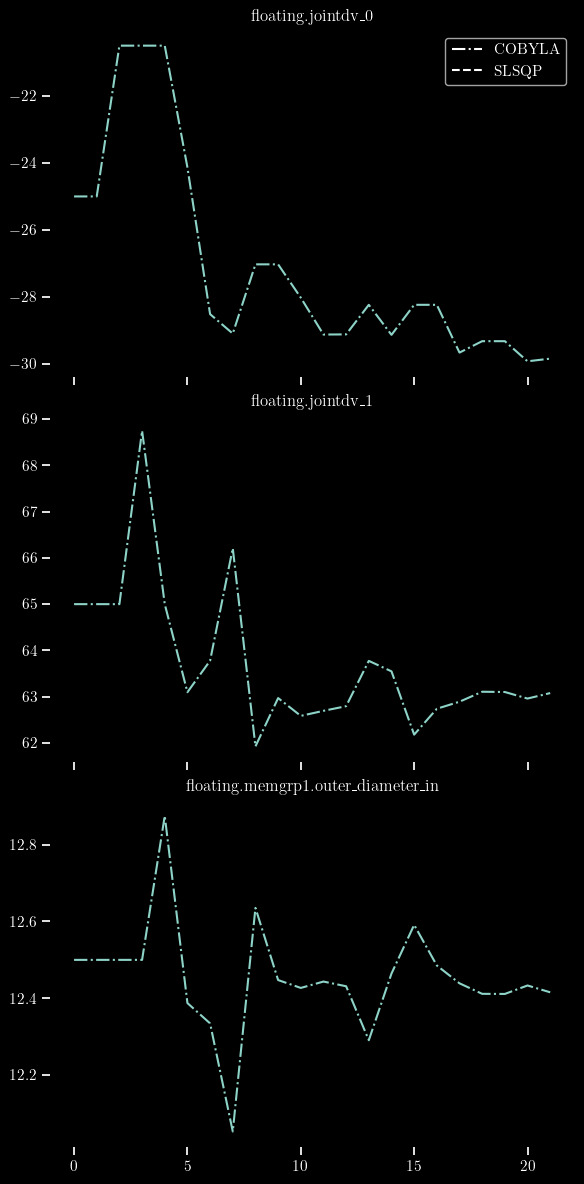

In [123]:
plot_conv(keys_DV)

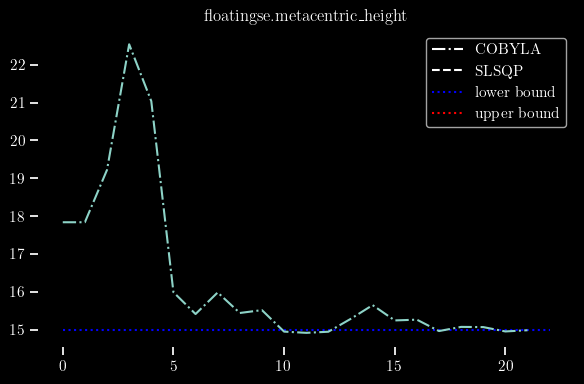

In [124]:
plot_conv(keys_constr)